In [1]:
import pandas as pd
import numpy as np
import pickle 
import re

import matplotlib.pyplot as plt
import pyecharts as pye
from wordcloud import WordCloud

from scipy.spatial.distance import cosine
from gensim.models import FastText

import sys
sys.path.append('../code')

from preprocessing import GlowpickPreprocessing, Filtering, l2norm
from loaddata import load
from clustering import Clustering

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [2]:
reviewpath = '../dataset/glowpick_reviews.csv' # review data path to load
productpath = '../dataset/glowpick_products.csv' # product data path to load
infopath = '../dataset/glowpick_info.csv' # product information path to load
savedir = '../saved_file' # saved files path
modelname = 'new_pre_embed' # preprocessed embedding model name

# load data
data, products, _ = load(reviewpath, productpath, infopath)

# preprocessing class
GP = GlowpickPreprocessing()

# wordcloud
wc = WordCloud(font_path='/usr/share/fonts/truetype/NanumGothic.ttf', 
               background_color="white", 
               min_word_length=2)

[LOAD           ] Load data...(data.shape: ,(461659, 7))(products.shape: ,(12698, 9))(infos.shape: ,(12243, 3))
[LOAD           ] filtering data...(filtering data shape: (10390, 4)


# Clustering

이후 추천상품에 대한 분석 결과로 사용하기 위해 이전 notebook에서 했던 군집분석 결과를 가져온다.

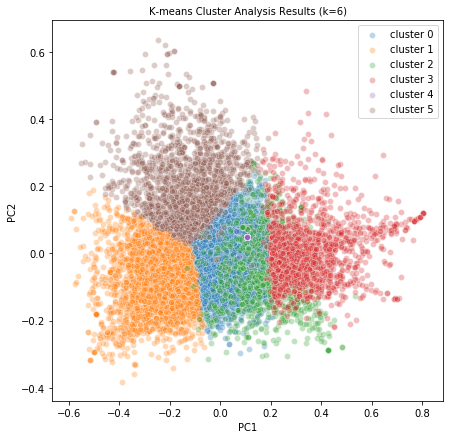

In [3]:
# load preprocessed data
embed_matrix = pickle.load(open('../saved_file/new_pre_embed_word_pos.pickle','rb'))
words = pickle.load(open('../saved_file/new_pre_text_word_pos.pickle','rb'))

# clustering (k=6)
cluster_k = Clustering(embed_matrix, words)
cluster_k.fit(k=6, figsize=(7,7))

words_df = cluster_k.words_df

# Recommendation Process

추천 과정을 크게 3가지로 구분된다. 
1. 새로운 입력값에 대해 전처리
2. 기존 데이터에 대해 임베딩된 벡터들과 유사도 계산
3. 규칙기반 필터링 과정

우선 새로운 문장(query)이 오면 전처리 과정을 통해서 문장에 대한 벡터를 구해야한다. 계산된 벡터는 리뷰데이터들의 벡터값들과 cosine similarity를 계산한 후 오름차순으로 정렬한다. 정렬된 결과에 대해서 위에서부터 순차적으로 일정 거리(d)보다 작을때가지 n개의 상품을 가져온다. 이때 정해진 규칙에 따라 약간의 필터링 과정이 필요한데 이는 리뷰 데이터가 10,390개로 상품 수가 3,481개인 것을 고려하면 많은 수는 아니기때문이다. 이후 더 많은 데이터가 수집된다면 정해진 규칙보다 사용자에 맞게 더 적절한 추천이 될 수 있을거라 생각한다.

In [4]:
def evaluation(search,
               modelname, 
               pre_embedname,
               savedir='../saved_file', 
               reviewpath='../dataset/glowpick_reviews.csv', 
               productpath='../dataset/glowpick_products.csv',
               infopath='../dataset/glowpick_info.csv'):
    
    print('[{0:15s}] Evaluation'.format('STATE'))
    # configuration
    GP = GlowpickPreprocessing()
    # - feature selection
    show_features = ['category','brand','nb_reviews','vol_price','product','product_url']
    # - load embed model
    model = FastText.load(f'{savedir}/{modelname}.bin')
    # - filtering class
    filtering = Filtering(show_features)

    # 1. load data
    data, products, info = load(reviewpath, productpath, infopath)

    # 2. preprocessing new sentence
    test_text = GP.fit([search], 
                       wordfix_path='../saved_file/replace_word.json', 
                       posfix_path='../saved_file/pos_dict.json')
    print('[{0:15s}] result : {1:}'.format('PREPROCESSING',test_text))
    test_sent_vec = GP.sent2vec(test_text, model)
    test_sent_vec = l2norm(test_sent_vec)

    # 3. calculration similarity : cosine distance
    sent_vec = pickle.load(open(f'{savedir}/{pre_embedname}.pickle','rb'))
    dist_arr = np.zeros((sent_vec.shape[0]))
    for i, sent in enumerate(sent_vec):
        dist = cosine(sent, test_sent_vec[0])
        dist_arr[i] = dist
    data['dist'] = dist_arr
    data = pd.merge(data, products, on='product_url', how='left')

    # 4. featering
    data = filtering.fit(data, test_text)

    return data

# Test

혼자사는 남자들을 위한 향 좋은 화장품을 찾기위해서 **"홀애비 냄새나는 남사친을 위한 향 좋은 제품"** 이라는 문장을 검색해보았다. 주변에 혼자사는 남사친들에게서 이런 생각을 해봤고 선물을 줘야하는 경우가 생겼다면 한 번 쯤 검색해서 괜찮은 제품이 뭐가 있을지 확인해볼 수 있다.

In [5]:
search = '홀애비 냄새나는 남사친을 위한 향 좋은 제품'

In [6]:
test = evaluation(search=search,
                  modelname='new_model_word_pos',
                  pre_embedname='new_pre_embed_word_pos')

[STATE          ] Evaluation
[LOAD           ] Load data...(data.shape: ,(461659, 7))(products.shape: ,(12698, 9))(infos.shape: ,(12243, 3))
[LOAD           ] filtering data...(filtering data shape: (10390, 4)
[PREPROCESSING  ]: complete stopword
Loading JIT Compiled ChatSpace Model
[PREPROCESSING  ]: complete spacefix
[PREPROCESSING  ]: complete wordfix
[PREPROCESSING  ]: complete posfix
[PREPROCESSING  ] result : [['홀애비', '냄새', '남사친']]
[FILTERING      ] number of reviews (data shape: (5834, 13))
[FILTERING      ] rating (data shape: (4320, 13))
[FILTERING      ] limited distance (data shape: (1081, 13))
[FILTERING      ] sorting and drop duplicates (data shape: (425, 6))


주로 향수 관련된 제품들이 많았다. 냄새를 없애는데 가장 좋은 방법인 것 같다. 그러나 가격을 고려했을때 다음에도 또 보고싶은 남사친이 아니라면 선물은 자제하는게 좋을 거 같다.

In [7]:
test.head(n=5)

,category,brand,nb_reviews,vol_price,product,product_url
11378,향초,양키캔들 (YANKEE CANDLE),113,"623g39,000원",미드나잇 쟈스민,/product/43548
10920,여성향수,안나수이 (ANNA SUI),193,"30ml62,000원",라뉘드 보헴 오 드 뚜왈렛,/product/16708
11067,남성향수,샤넬 (CHANEL),59,"50ml114,000원",블루 드 샤넬 오 드 빠르펭,/product/16788
10992,남성향수,샤넬 (CHANEL),89,"100ml140,000원",알뤼르 옴므 스포츠 오 드 뚜왈렛 스프레이,/product/3297
11192,남성향수,페라리 (Ferrari),206,"40ml45,000원",스쿠데리아 블랙 EDT,/product/3338


# Visualization Reviews Using WordCloud

키워드는 향수/냄새/느낌/여자/친구/잔향 이 눈에 띈다.

In [9]:
words_df['product_url'] = data.product_url.values
rys_df = words_df[words_df.product_url.isin(test.product_url)]
rys_df = rys_df[rys_df.labels!=4]

In [27]:
words_product_df = pd.merge(words_df, products, on='product_url', how='left')
rys_df = words_product_df.iloc[test.index]
rys_df = rys_df[rys_df.labels!=4]
words_n4_df = words_df[words_df.labels!=4]

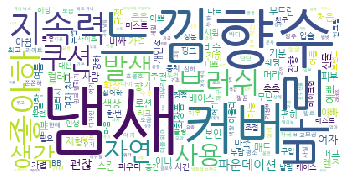

In [24]:
wc2 = wc.generate(' '.join(rys_df.content.tolist()))
plt.imshow(wc2)
plt.axis('off')
plt.show()

# Clustering Analysis Using Radar Chart

추천된 목록의 리뷰들에 대해 앞서 분류한 군집들간 비교해보았을때 검색 키워드에 맞게 "홀애비탈출키트" 지수가 가장 높았다. 추천 상품들에 대한 평이 향과 관련된 내용들이라는 것을 알 수 있다.

In [124]:
rys_schema = rys_df.labels.value_counts().sort_index()
total_schema = words_n4_df.labels.value_counts().sort_index()
cluster_dict = {
    0:'신사의품격',
    1:'가뭄의단비',
    2:'홀애비탈출키트',
    3:'미용실가지뫄',
    5:'피부영세시대'
}

rys_schema.index = rys_schema.index.map(cluster_dict)
total_schema.index = total_schema.index.map(cluster_dict)

total_schema = total_schema / 5
total_schema = list(zip(total_schema.index, total_schema))

In [127]:
radar = pye.Radar(width=500,height=300)
v1 = [rys_schema.tolist()]
radar.config(total_schema)
radar.add("",v1)
radar